<a href="https://colab.research.google.com/github/g-nyuk/Demand-Side_Fluctuation/blob/Constant-Conditions/(Constant_Demand)Demand_Side_Fluctuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#INITIAL CONDITION - FIRM
INITIAL_CAPITAL = 100
INITIAL_PATHNUM = 1

#COMPETION CONDITON
PROBABILITY = 0.25
COMPENSATION = 40
UNIT_EXPENDITURE = 10
TIME_DURATION = 100

In [ ]:
class Firm:
    def __init__(self, name, capital=INITIAL_CAPITAL, numPath=INITIAL_PATHNUM, unit_expenditure=UNIT_EXPENDITURE, compensation=COMPENSATION):
        self.name = name
        self.capital = capital
        self.numPath = numPath
        self.unit_expenditure = unit_expenditure
        self.compensation = compensation
        self.bankrupt = False

    def invest(self):
        if self.capital < self.unit_expenditure * self.numPath:
            self.bankrupt = True
            return 0

        self.capital -= self.unit_expenditure * self.numPath

        successes = sum(random.random() < PROBABILITY for _ in range(self.numPath))
        self.capital += successes * self.compensation

        if self.capital // 100 > self.numPath :
            self.numPath += 1

        if self.capital // 100 < self.numPath and self.numPath != 1 :
            self.numPath -= 1

        return successes

In [ ]:
firms = [Firm(f'Firm {chr(65+i)}') for i in range(2)]
data = []

df = pd.DataFrame()

for timestep in range(TIME_DURATION):
    for firm in firms:
        if firm.bankrupt:
            continue
        successes = firm.invest()
        data.append({'timestep': timestep, 'firm': firm.name, 'successes': successes, 'capital': firm.capital, 'numPath': firm.numPath})

        df = pd.concat([pd.DataFrame([i]) for i in data], ignore_index=True)
        df = df.astype({'timestep': int, 'successes': int, 'capital': np.float64, 'numPath': int})

In [ ]:
df

,timestep,firm,successes,capital,numPath
0,0,Firm A,0,90.0,1
1,0,Firm B,0,90.0,1
2,1,Firm A,0,80.0,1
3,1,Firm B,0,80.0,1
4,2,Firm A,1,110.0,1
...,...,...,...,...,...
158,95,Firm A,1,130.0,1
159,96,Firm A,0,120.0,1
160,97,Firm A,0,110.0,1
161,98,Firm A,1,140.0,1


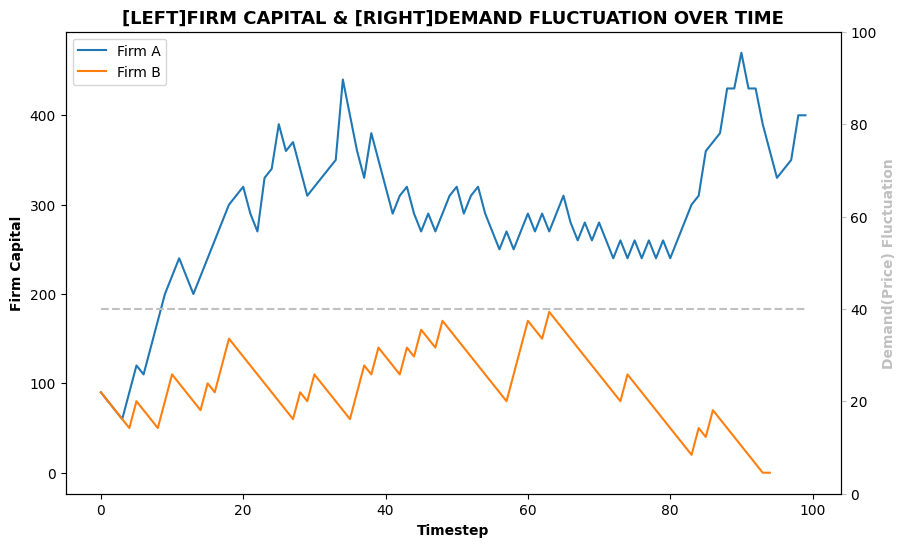

In [ ]:
firm_a = df[df['firm'] == 'Firm A']
firm_b = df[df['firm'] == 'Firm B']

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()

ax1.plot(firm_a['timestep'], firm_a['capital'], label='Firm A')
ax1.plot(firm_b['timestep'], firm_b['capital'], label='Firm B')
ax1.set_xlabel('Timestep', fontweight = 'bold', fontsize = 10)
ax1.set_ylabel('Firm Capital', fontweight = 'bold', fontsize = 10)
ax1.tick_params(axis='y')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(firm_a['timestep'], [40 for _ in range(len(firm_a['timestep']))], '--', color = 'silver')
ax2.set_ylabel('Demand(Price) Fluctuation', fontweight = 'bold', color = 'silver', fontsize = 10)
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color = 'silver')


plt.title('[LEFT]FIRM CAPITAL & [RIGHT]DEMAND FLUCTUATION OVER TIME', fontweight = 'heavy', fontsize = 13)
plt.show()

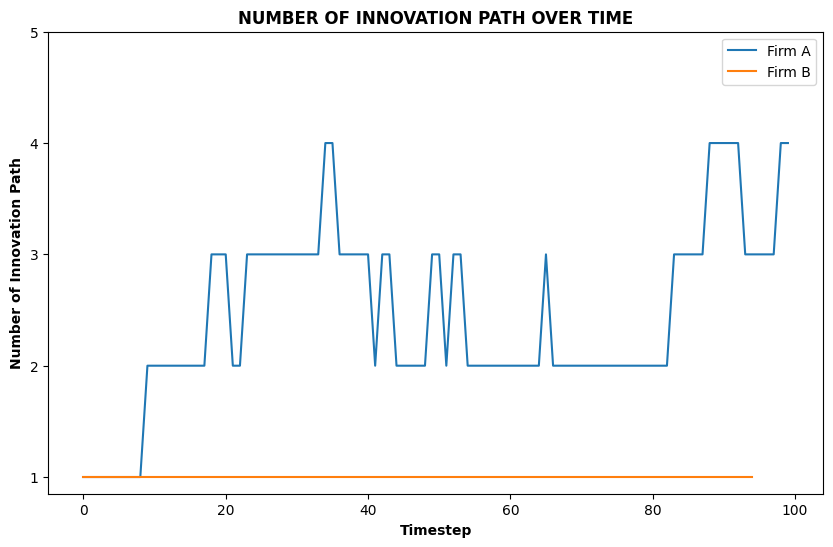

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(firm_a['timestep'], firm_a['numPath'], label='Firm A')
plt.plot(firm_b['timestep'], firm_b['numPath'], label='Firm B')

plt.xlabel('Timestep', fontweight = 'bold', fontsize = 10)
plt.ylabel('Number of Innovation Path',  fontweight = 'bold', fontsize = 10)
plt.legend()
plt.title('NUMBER OF INNOVATION PATH OVER TIME', fontweight = 'heavy', fontsize = 12)
plt.yticks([1,2,3,4,5])
plt.show()